# Visualisation of mean reversion in action

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## 1: Calculating market beta

In [2]:
stock = "AAPL"
market = "^GSPC"
period = "2y"

stock_returns = yf.download(stock, period=period, auto_adjust=True)["Close"]
market_returns = yf.download(market, period=period, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
stock_returns = pd.DataFrame(stock_returns)
stock_returns["LogReturn"] = np.log(1+stock_returns[stock]) - np.log(1+stock_returns[stock].shift(1))

In [4]:
market_returns = pd.DataFrame(market_returns)
market_returns["LogReturn"] = np.log(1+market_returns[market]) - np.log(1+market_returns[market].shift(1))

In [5]:
df = pd.concat([market_returns["LogReturn"],stock_returns["LogReturn"]], axis=1)
df.columns = ["Market",stock]

In [6]:
df.head()

,Market,AAPL
Date,,
2023-05-08,NaN,NaN
2023-05-09,-0.004589,-0.009963
2023-05-10,0.004473,0.010307
2023-05-11,-0.001698,0.001088
2023-05-12,-0.001584,-0.005401


In [7]:
df = df.dropna()

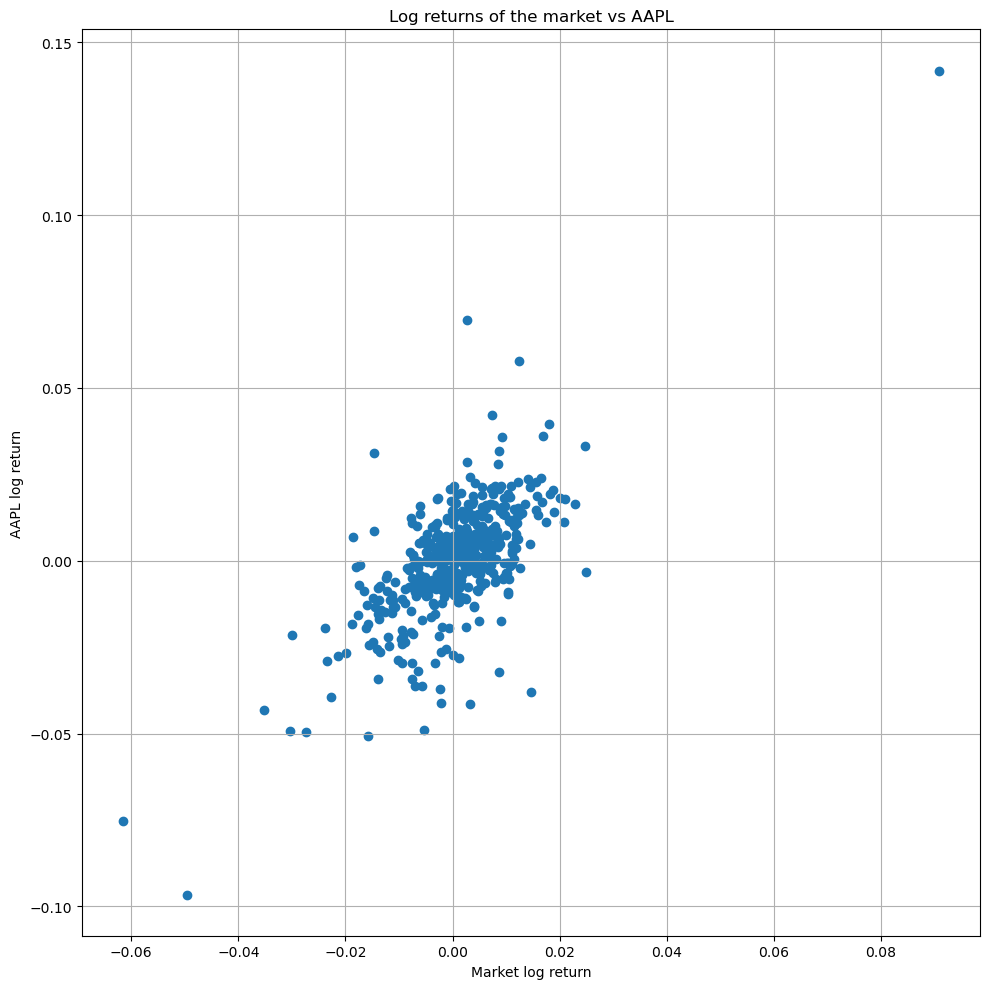

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(df["Market"],df[stock])
plt.title(f"Log returns of the market vs {stock}")
plt.xlabel("Market log return")
plt.ylabel(f"{stock} log return")
plt.grid(True)
plt.tight_layout()
plt.show()

$$
\beta_{ds} = \frac{\sum_{d{\prime} \leq d} u_{d{\prime}} R_{d{\prime}s} M_{d{\prime}}}{\sum_{d{\prime} \leq d} u_{d{\prime}} M_{d{\prime}}^2}
$$

### Formula I will be using to estimate the stocks market beta

In [9]:
numerator = (df[stock]*df["Market"]).sum()
denominator = (df["Market"]**2).sum()
beta = numerator/denominator

print(f"Market beta of {stock} is {beta:.4f}")

Market beta of AAPL is 1.1643


In [10]:
beta_func = np.poly1d([beta,0])

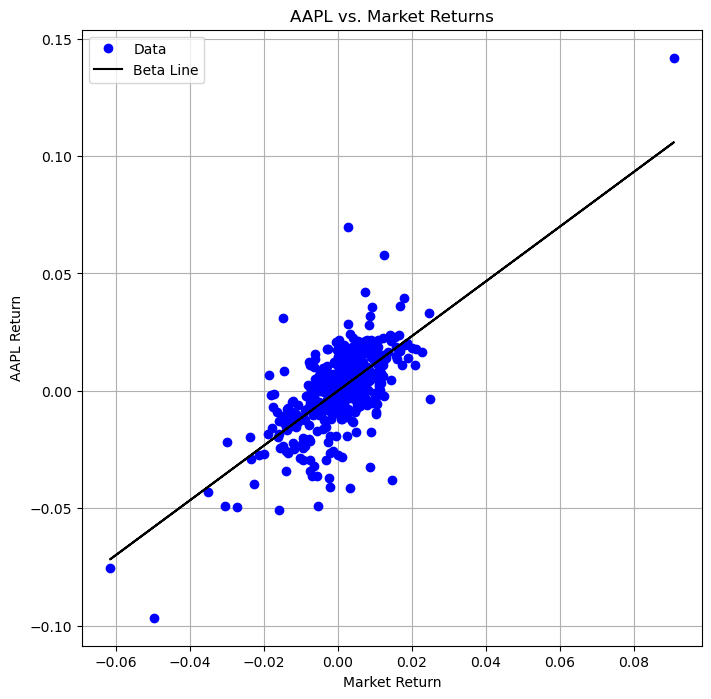

In [11]:
plt.figure(figsize=(8,8))
plt.plot(df["Market"], df[stock], 'bo', label='Data')

plt.plot(df["Market"], beta_func(df["Market"]), 'k-', label='Beta Line')

plt.xlabel("Market Return")
plt.ylabel(f"{stock} Return")
plt.legend()
plt.grid(True)
plt.title(f"{stock} vs. Market Returns")
plt.show()

# Calculating and plotting residuals satisfying the following:

$$
R_{ds} = \beta_{ds} M_d + r_{ds}
$$

In [12]:
df.head()

,Market,AAPL
Date,,
2023-05-09,-0.004589,-0.009963
2023-05-10,0.004473,0.010307
2023-05-11,-0.001698,0.001088
2023-05-12,-0.001584,-0.005401
2023-05-15,0.002953,-0.002885


In [13]:
df["Beta"] = (df["Market"]*df[stock])/(df["Market"]**2)

In [14]:
df.head()

,Market,AAPL,Beta
Date,,,
2023-05-09,-0.004589,-0.009963,2.171103
2023-05-10,0.004473,0.010307,2.304290
2023-05-11,-0.001698,0.001088,-0.640685
2023-05-12,-0.001584,-0.005401,3.409206
2023-05-15,0.002953,-0.002885,-0.976820


In [15]:
df["Residuals"] = df[stock]-(df["Beta"]*df["Market"])

In [16]:
df.head()

,Market,AAPL,Beta,Residuals
Date,,,,
2023-05-09,-0.004589,-0.009963,2.171103,0.000000e+00
2023-05-10,0.004473,0.010307,2.304290,1.734723e-18
2023-05-11,-0.001698,0.001088,-0.640685,-2.168404e-19
2023-05-12,-0.001584,-0.005401,3.409206,8.673617e-19
2023-05-15,0.002953,-0.002885,-0.976820,-4.336809e-19


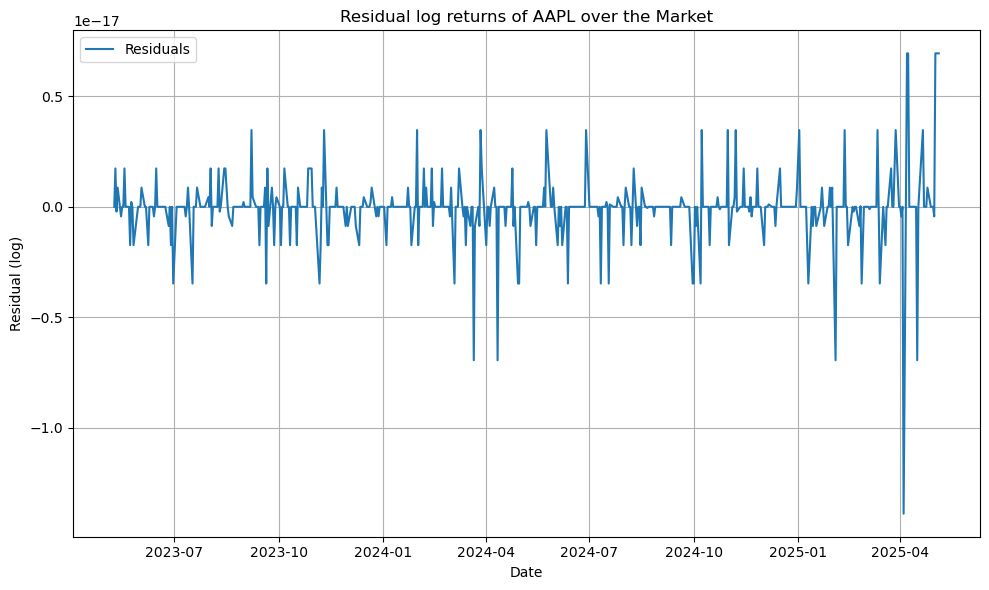

In [17]:
plt.figure(figsize=(10,6))
plt.plot(df["Residuals"], label="Residuals")
plt.title(f"Residual log returns of {stock} over the Market")
plt.xlabel("Date")
plt.ylabel("Residual (log)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### As can be seen, residual returns are mean reverting to 0 

# Cross-sectional regression model to estimate \$\displaystyle \beta^{(mr)}$

In [18]:
def calculate_bmr(df,stock):
    betas = []
    for d in range(1,len(df)):
        r_next = df[stock].iloc[1:d+1]

        r_market_prev = df["Market"].iloc[:d]
        u = 1

        numerator = np.sum(u*r_market_prev*r_next)
        denominator = np.sum(u*r_market_prev**2)

        beta_mr = numerator/denominator if denominator != 0 else 0

        betas.append(beta_mr)

    return pd.Series(betas, index=df.index[1:])


df['Beta_MR'] = calculate_bmr(df, stock)

In [19]:
df.head()

,Market,AAPL,Beta,Residuals,Beta_MR
Date,,,,,
2023-05-09,-0.004589,-0.009963,2.171103,0.000000e+00,NaN
2023-05-10,0.004473,0.010307,2.304290,1.734723e-18,0.000000
2023-05-11,-0.001698,0.001088,-0.640685,-2.168404e-19,1.122660
2023-05-12,-0.001584,-0.005401,3.409206,8.673617e-19,1.007017
2023-05-15,0.002953,-0.002885,-0.976820,-4.336809e-19,1.136789


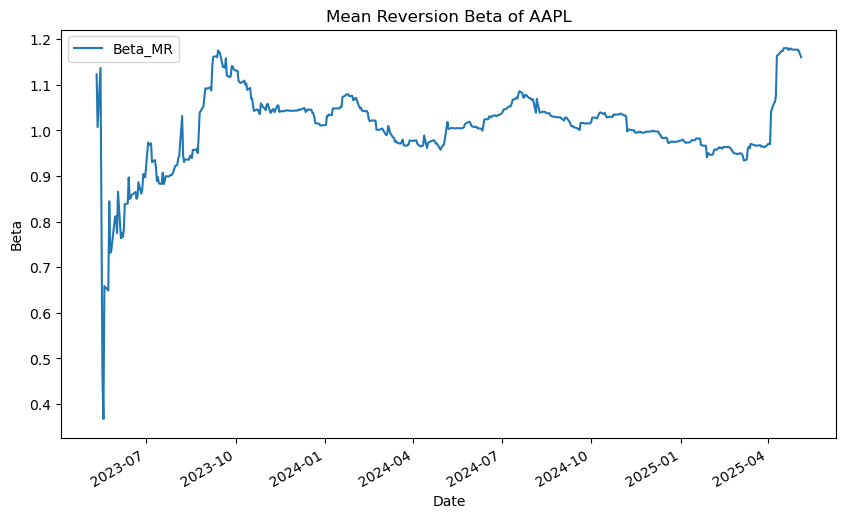

In [20]:
df = df.dropna()
df = df.iloc[1:]
df[['Beta_MR']].plot(figsize=(10,6))
plt.title(f'Mean Reversion Beta of {stock}')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.show()

# Now lets calculate and plot how much noise plays into \$\displaystyle r_{d+1,s}$

### Equation used: \$\displaystyle r_{d+1,s} = \beta^{(mr)} r_{ds} + \epsilon_{ds}$

In [21]:
def calculate_noise(df, stock):
    noises = []

    for d in range(1,len(df)-1):
        r_next = df[stock].iloc[d+1]
        r_today = df[stock].iloc[d]
        beta_mr = df['Beta_MR'].iloc[d]

        noise = r_next-(beta_mr*r_today)

        noises.append(noise)

    return pd.Series(noises, index=df.index[1:-1])

df["Noise"] = calculate_noise(df, stock)

In [22]:
df = df.dropna()

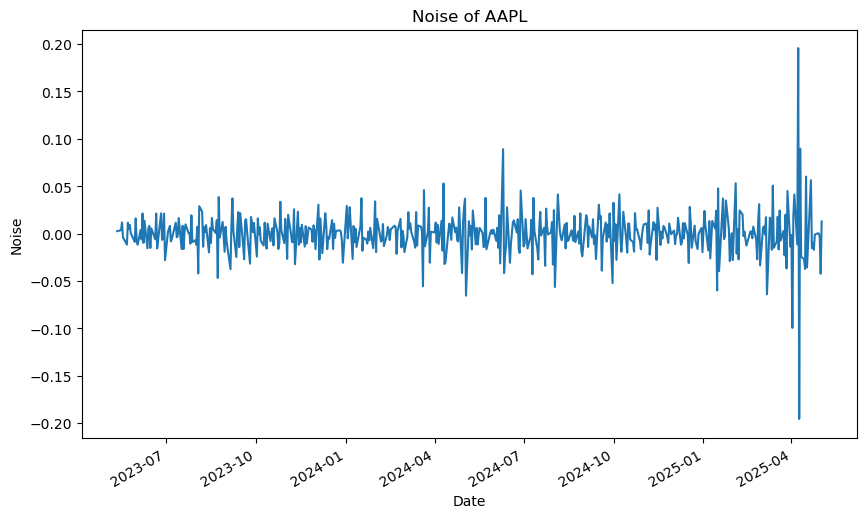

In [23]:
df["Noise"].plot(figsize=(10,6))
plt.title(f'Noise of {stock}')
plt.xlabel('Date')
plt.ylabel('Noise')
plt.show()

# Finally, lets verify to see if the equations log change equals real log change

In [24]:
df.head()

,Market,AAPL,Beta,Residuals,Beta_MR,Noise
Date,,,,,,
2023-05-12,-0.001584,-0.005401,3.409206,8.673617e-19,1.007017,0.002554
2023-05-15,0.002953,-0.002885,-0.976820,-4.336809e-19,1.136789,0.003279
2023-05-16,-0.006397,0.000000,-0.000000,0.000000e+00,0.802729,0.003576
2023-05-17,0.011818,0.003576,0.302566,0.000000e+00,0.460927,0.011847
2023-05-18,0.009398,0.013495,1.435914,1.734723e-18,0.367113,-0.004330


In [25]:
def compute_log(df,stock):
    computed_logs = []
    for d in range(0, len(df)-1):
        beta_mr = df['Beta_MR'].iloc[d]
        r_today = df[stock].iloc[d]
        noise_today = df['Noise'].iloc[d]

        computed_log = beta_mr*r_today + noise_today
        computed_logs.append(computed_log)

    computed_logs.append(float('nan'))

    return pd.Series(computed_logs, index=df.index)


df.loc[:, "ComputedLogs"] = compute_log(df,stock)

In [26]:
df.head()

,Market,AAPL,Beta,Residuals,Beta_MR,Noise,ComputedLogs
Date,,,,,,,
2023-05-12,-0.001584,-0.005401,3.409206,8.673617e-19,1.007017,0.002554,-0.002885
2023-05-15,0.002953,-0.002885,-0.976820,-4.336809e-19,1.136789,0.003279,0.000000
2023-05-16,-0.006397,0.000000,-0.000000,0.000000e+00,0.802729,0.003576,0.003576
2023-05-17,0.011818,0.003576,0.302566,0.000000e+00,0.460927,0.011847,0.013495
2023-05-18,0.009398,0.013495,1.435914,1.734723e-18,0.367113,-0.004330,0.000625


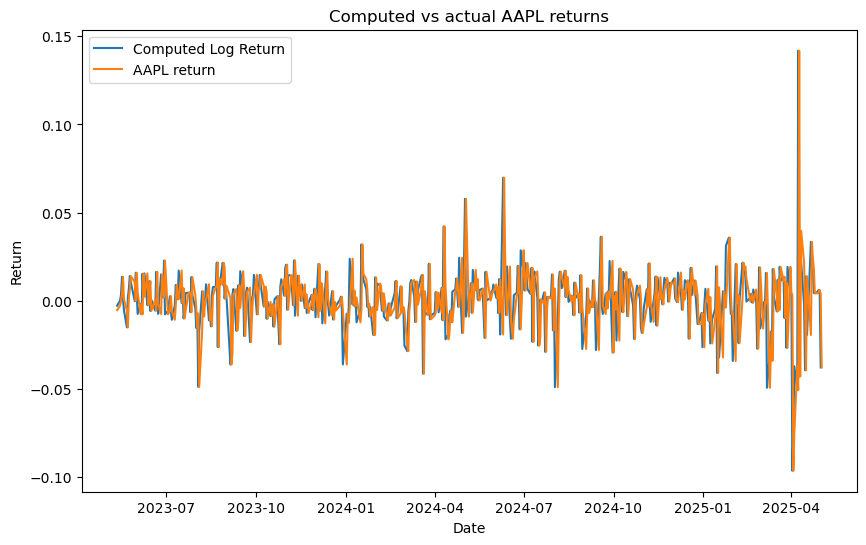

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df["ComputedLogs"],label="Computed Log Return")
plt.plot(df[stock],label=f"{stock} return")
plt.title(f'Computed vs actual {stock} returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

### As can be seen, computed log returns match actual stock returns, albeit one day in advance 